In [ ]:
#@title Setup Repository
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd
%cd /content/

! pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/orpatashnik/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2
%matplotlib inline

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
class Downloader(object):
    def __init__(self):
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
        os.makedirs(self.save_dir, exist_ok=True)


    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        !gdown --id $file_id -O $file_dst

downloader = Downloader()

## Step 1: Model Setup
Select which experiment you wish to perform inference on:
1. ffhq_encode
2. cars_encode
3. horse_encode
4. church_encode

In [ ]:
experiment_type = 'ffhq_encode' #@param ['ffhq_encode', 'cars_encode', 'horse_encode', 'church_encode']

In [ ]:
 #@title Download
MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
downloader.download_file(file_id=path["id"], file_name=path["name"])

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO
From (redirected): https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO&confirm=t&uuid=319b9ce5-1c42-4abc-a8fd-ec107ebcace2
To: /content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt
100% 1.20G/1.20G [00:12<00:00, 96.4MB/s]


In [ ]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": "notebooks/images/finally_no_smile.png"
    }
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

In [ ]:
 model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


In [ ]:
%cd
%cd /content/StyleCLIP/global_torch/
dataset_name='ffhq'
if not os.path.isfile('./model/'+dataset_name+'.pkl'):
        url='https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/'
        name='stylegan2-'+dataset_name+'-config-f.pkl'
        os.system('wget ' +url+name + '  -P  ./model/')
        os.system('mv ./model/'+name+' ./model/'+dataset_name+'.pkl')


# input prepare data
import clip
from manipulate import Manipulator
from StyleCLIP import GetDt,GetBoundary


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device,jit=False)

network_pkl='./model/'+dataset_name+'.pkl'
device = torch.device('cuda')
M=Manipulator()
M.device=device
G=M.LoadModel(network_pkl,device)
M.G=G
M.SetGParameters()
num_img=100_000
M.GenerateS(num_img=num_img)
M.GetCodeMS()
np.set_printoptions(suppress=True)

file_path='./npy/'+dataset_name+'/'
fs3=np.load(file_path+'fs3.npy')

/root
/content/StyleCLIP/global_torch
name:conv1_resolution_4 Resolution: 4, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_4 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_8 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_16 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_32 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_64 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_128 Resolution: 128, InC: 512,

## Prepare the image

In [ ]:
%cd /content/encoder4editing

/content/encoder4editing


In [ ]:
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

--2024-04-30 14:41:16--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  36.3MB/s    in 1.7s    

2024-04-30 14:41:18 (36.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


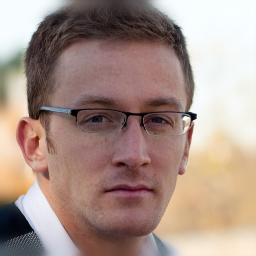

In [ ]:
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

In [ ]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

In [ ]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

Inference took 1.3569 seconds.


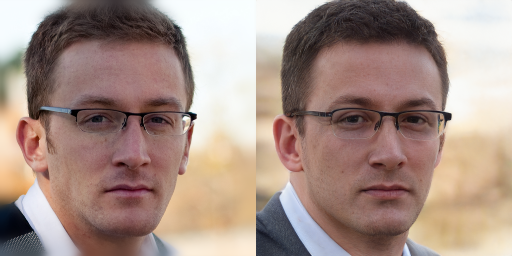

In [ ]:
with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

# Save initial features

In [ ]:
G2 = net.decoder
# synth_net2 = list(G2.named_children())[0][1]

In [ ]:
import random
def custom_forward(G2,
            styles,
            return_latents=False,
            return_features=False,
            inject_index=None,
            truncation=1,
            truncation_latent=None,
            input_is_latent=False,
            noise=None,
            randomize_noise=True, #careful with demoduate
    ):
    features = []
    if not input_is_latent:
        print("creating styles")
        styles = [G2.style(s) for s in styles]

    if noise is None:
        if randomize_noise:
            noise = [None] * G2.num_layers
        else:
            noise = [
                getattr(G2.noises, f'noise_{i}') for i in range(G2.num_layers)
            ]

    if truncation < 1:
        style_t = []

        for style in styles:
            style_t.append(
                truncation_latent + truncation * (style - truncation_latent)
            )

        styles = style_t

    if len(styles) < 2:
        inject_index = G2.n_latent

        if styles[0].ndim < 3:
            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            print("this")
        else:
            latent = styles[0]
            print(latent.shape)

    else:
        if inject_index is None:
            inject_index = random.randint(1, G2.n_latent - 1)

        latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
        latent2 = styles[1].unsqueeze(1).repeat(1, G2.n_latent - inject_index, 1)


        latent = torch.cat([latent, latent2], 1)

    out = G2.input(latent)
    out = G2.conv1(out, latent[:, 0], noise=noise[0])

    skip = G2.to_rgb1(out, latent[:, 1])

    i = 1


    for conv1, conv2, noise1, noise2, to_rgb in zip(
            G2.convs[::2], G2.convs[1::2], noise[1::2], noise[2::2], G2.to_rgbs
    ):
        out = conv1(out, latent[:, i], noise=noise1)
        out = conv2(out, latent[:, i + 1], noise=noise2)
        if i in [3,5,7,9, 11]:
            features.append(out)
        skip = to_rgb(out, latent[:, i + 2], skip)

        i += 2
    return features, skip, latent

In [ ]:
features, img,latent_new = custom_forward(G2, [latents], input_is_latent=True) #True for latents from W!! doble-check!!

torch.Size([1, 18, 512])


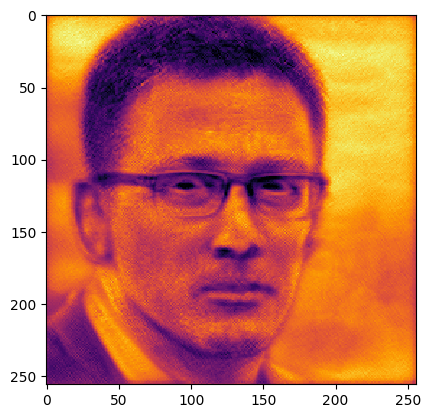

In [ ]:
plt.imshow(np.abs(features[4][0, 1, :, :].cpu().detach().numpy()), cmap='inferno', interpolation='nearest')

In [ ]:
synth_net = M.G.synthesis

In [ ]:
from torch_utils import misc
def get_feature_maps(latents, codes):
    ws = latents
    features = []
    if codes is None:
        block_ws = []
        with torch.autograd.profiler.record_function('split_ws'):
            misc.assert_shape(ws, [None, synth_net.num_ws, synth_net.w_dim])
            ws = ws.to(torch.float32)
            w_idx = 0
            for res in synth_net.block_resolutions:
                block = getattr(synth_net, f'b{res}')
                block_ws.append(ws.narrow(1, w_idx, block.num_conv + block.num_torgb))
                w_idx += block.num_conv
        x = img = None
        block_number = 0
        for res, cur_ws in zip(synth_net.block_resolutions[:7], block_ws):
            block = getattr(synth_net, f'b{res}')
            x, img = block(x, img, cur_ws)
            if block_number >= 2 and block_number <= 6:
                features.append(x)
            block_number += 1
    else:
        x = img = None
        block_number = 0
        tmp_code=[]
        for m in range(len(M.s_names)):
            tmp=codes[m][0,0][None,:]
            tmp_code.append(tmp)
        encoded_styles=M.SL2D(tmp_code)

        for res in synth_net.block_resolutions[:7]:
            block = getattr(synth_net, f'b{res}')
            x, img = block(x, img, None, encoded_styles=encoded_styles)
            if block_number >= 2 and block_number <= 6:
                features.append(x)
            block_number += 1
    return features

In [ ]:
features = get_feature_maps(latents, None)

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
features_for_methods = {}

In [ ]:
features_for_methods["original"] = features

## Edits

#### **Interface**

In [ ]:
%cd /content/encoder4editing

/content/encoder4editing


In [ ]:
from editings import latent_editor
is_cars = experiment_type == 'cars_encode'
editor = latent_editor.LatentEditor(net.decoder, is_cars)

In [ ]:
# InterFaceGAN
interfacegan_directions = {
    'ffhq_encode': {
        'age': 'editings/interfacegan_directions/age.pt',
        'smile': 'editings/interfacegan_directions/smile.pt',
        'pose': 'editings/interfacegan_directions/pose.pt'
    }
}
available_interfacegan_directions = None
if experiment_type in interfacegan_directions:  # List supported directions for the current experiment
    available_interfacegan_directions = interfacegan_directions[experiment_type]
    print(list(available_interfacegan_directions.keys()))

['age', 'smile', 'pose']


In [ ]:
def apply_interfacegan_latents(latent, direction, factor=1, factor_range=None):
    edit_latents = []
    if factor_range is not None:  # Apply a range of editing factors. for example, (-5, 5)
        for f in range(*factor_range):
            edit_latent = latent + f * direction
            edit_latents.append(edit_latent)
        edit_latents = torch.cat(edit_latents)
    else:
        edit_latents = latent + factor * direction
    return edit_latents

In [ ]:
# As an example, we currently released the age and smile directions for the FFHQ StyleGAN Generator.
interfacegan_direction = torch.load(available_interfacegan_directions["smile"]).cuda()

# For a single edit:
# result = editor.apply_interfacegan(latents, interfacegan_direction, factor=1.6).resize(resize_dims)
# display_alongside_source_image(result, input_image)

In [ ]:
edit_latents_interface = apply_interfacegan_latents(latents, interfacegan_direction, factor=1.6)

In [ ]:
result.resize((256,256))

#### **GANSpace**

In [ ]:
from editings import ganspace
def apply_ganspace_latents(latent, ganspace_pca, edit_directions):
    edit_latents = ganspace.edit(latent, ganspace_pca, edit_directions)
    return edit_latents

Available Editings: ['smile', 'gray_hair']


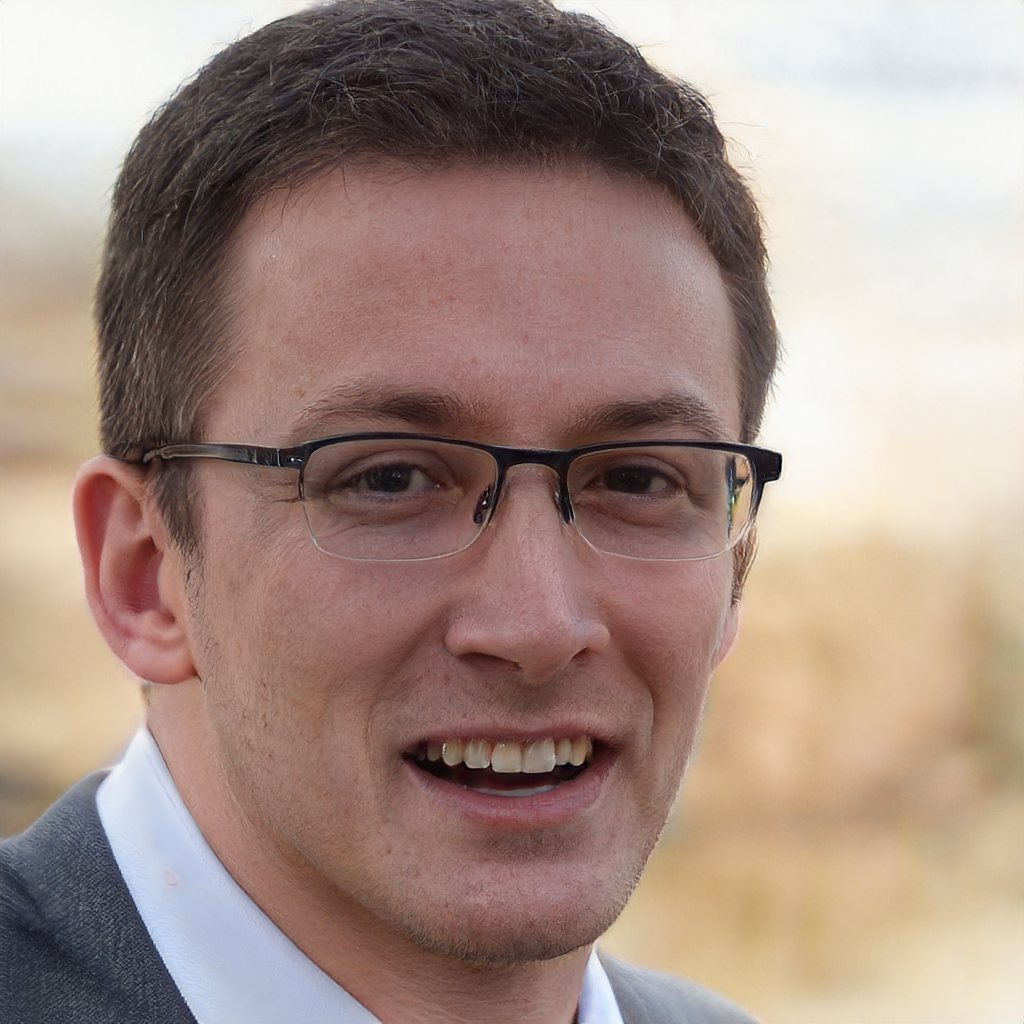

In [ ]:
# GANSpace
ganspace_pca = torch.load('editings/ganspace_pca/ffhq_pca.pt')
directions = {
        'smile':                   (46,  4,  5,  -20),
        'gray_hair':               (57,7,10,-22)
    }
print(f'Available Editings: {list(directions.keys())}')
editor.apply_ganspace(latents, ganspace_pca, [directions["smile"]])

In [ ]:
edit_latents_ganspace = apply_ganspace_latents(latents, ganspace_pca, [directions["smile"]])

#### **Methods group 2**

#### **StyleClip**

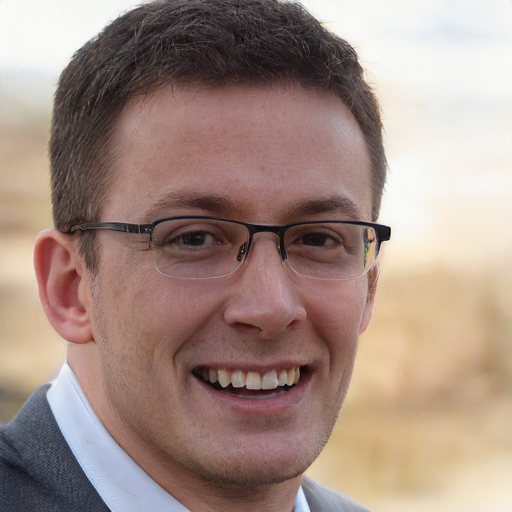

In [ ]:
# if mode == 'real image':
img_index = 0
dlatents_loaded=M.G.synthesis.W2S(latents)

img_indexs=[img_index]
dlatents_loaded=M.S2List(dlatents_loaded)

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
# elif mode == 'generated image':
#   img_indexs=[img_index]
#   dlatents_loaded=M.S2List(dlatents_loaded)
#   dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]

M.num_images=len(img_indexs)
M.alpha=[-6.5]
lindex, cindex = 6, 501

M.manipulate_layers=[lindex]
codes_stylespace,out=M.EditOneC(cindex, dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

#### **StyleClip**

In [ ]:
mode='real image' #@param ['real image', 'generated image']

if mode == 'real image':
  img_index = 0
  dlatents_loaded=M.G.synthesis.W2S(latents)

  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)

  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None

In [ ]:
neutral='face' #@param {type:"string"}
target='face with a smile' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

AttributeError: 'str' object has no attribute 'encode_text'

In [ ]:
beta = 0.21 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 4 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes_styleclip=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes_styleclip)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

### Let's save feature maps for all editings

In [ ]:
interface_features = get_feature_maps(edit_latents_interface, None)
ganspace_features = get_feature_maps(edit_latents_ganspace, None)
stylespace_features = get_feature_maps(None, codes_stylespace)
styleclip_features = get_feature_maps(None, codes_styleclip)

In [ ]:
# features = custom_forward(G2, [latents])
# interface_features = custom_forward(G2,[edit_latents_interface])
# ganspace_features = custom_forward(G2, [edit_latents_ganspace])

In [ ]:
# for other 2 methods change G.conv1 and self.convs list. Set demodulate=True,

### Let's compare features

In [ ]:
argmax_channels_for_methods = {"interface": [], "ganspace":[], "stylespace":[], "styleclip":[]}
mean_norms = {"interface": [], "ganspace":[], "stylespace":[], "styleclip":[]}
#argmax_channels_for_methods = {"ganspace":[], "stylespace":[], "styleclip":[]}

In [ ]:
denoms = [10,10,10,10,10]

In [ ]:
def find_best_channels(method_features, features, method_name="interface"):
    method_dif = []
    method_norms = []
    channel_layers = []
    for i, layer in enumerate(method_features):
        layer_dif = (layer - features[i])[0]
        layer_norm = torch.norm(layer_dif, p=1, dim=(1,2)) / (layer_dif.shape[1]**2)
        method_dif.append(layer_dif)
        method_norms.append(layer_norm)
        argmax_channels = torch.argsort(layer_norm).cpu().numpy()[::-1][:denoms[i]]
        channel_layers.append(layer_norm.mean().item())
        print(argmax_channels)
        argmax_channels_for_methods[method_name].append(argmax_channels)
    mean_norms[method_name] = channel_layers
    return method_dif, method_norms

**GIRL**

In [ ]:
dif_features_interface, map_norms_interface = find_best_channels(interface_features, features, method_name="interface")

[122 440 381  14 140 317 120 477   6 174]
[231 432 383 150  10  25 163  77 152 475]
[145 441 291 445 285 214 203  66 263   3]
[101 243 152 165 128 150 106 252 237  60]
[ 55  37 126  42  14 119  86  71  80  39]


In [ ]:
dif_features_ganspace, map_norms_gnaspace = find_best_channels(ganspace_features, features, method_name="ganspace")

[122 251 118 389 219 120 308 328 317 440]
[383 163 231 432 488 279 345  55  77  25]
[145 291 441 263 445 214 203 456  66 455]
[152 128 101 165 106 243 138   5 150  60]
[ 55  37 126  42 119  71  91  86  14  39]


In [ ]:
dif_features_stylespace, map_norms_stylespace = find_best_channels(stylespace_features, features, method_name="stylespace")

[122 389 317 381 118 395 399 319 156 440]
[163 383 231 432 279  62 488 152 223  10]
[ 66 214 455 445 441 291 145 127 223 108]
[152 101 165 128 243 138 145   5 252 106]
[ 37 126  55 119  42  91  39  86   2  80]


In [ ]:
dif_features_styleclip, map_norms_styleclip = find_best_channels(styleclip_features, features, method_name="styleclip")

[122 440 503  14 140 279 370 126 343 477]
[231 432 383 152  10 163  62 488 345  77]
[445 214 441 203 145  66 455 291 223 108]
[152 101 165 243 128   5 106 138 252 145]
[ 37 126  55  42 119  91  39  71   2  80]


In [ ]:
mean_norms

{'interface': [0.05734933912754059,
  0.19532686471939087,
  0.27316832542419434,
  0.3080357313156128,
  0.16287651658058167],
 'ganspace': [0.08648894727230072,
  0.20684930682182312,
  0.2876104414463043,
  0.31871700286865234,
  0.16578197479248047],
 'stylespace': [0.05997069180011749,
  0.21097832918167114,
  0.2958265542984009,
  0.3240763545036316,
  0.16445723176002502],
 'styleclip': [0.0761285126209259,
  0.217683345079422,
  0.29105040431022644,
  0.32000768184661865,
  0.16494470834732056]}

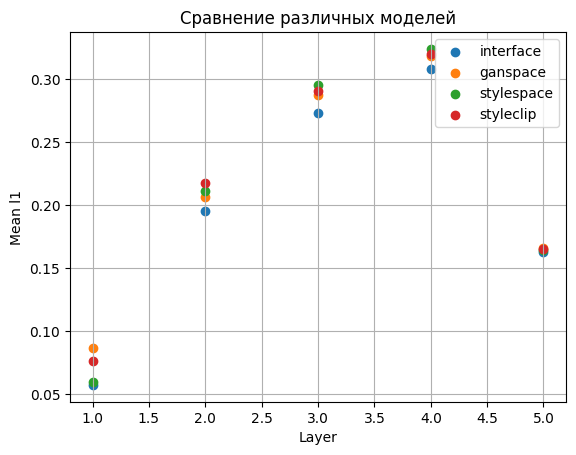

In [ ]:
import matplotlib.pyplot as plt

# Данные для визуализации
data = mean_norms
# Создание линейного графика
for model, values in data.items():
    plt.scatter(range(1, len(values)+1), values, label=model)

# Добавление подписей
plt.title('Сравнение различных моделей')
plt.xlabel('Layer')
plt.ylabel('Mean l1')
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()


**MAN**

In [ ]:
#dif_features_interface, map_norms_interface = find_best_channels(interface_features, features, method_name="interface")

In [ ]:
dif_features_ganspace, map_norms_gnaspace = find_best_channels(ganspace_features, features, method_name="ganspace")

[7 6]
[6 7 5 8 4]
[ 8  9 12 11 10  7 13 14 15  6]
[14 13 15 12 16 24 23 25 22 17 11 26 21 20 19]
[29 28 30 27 31 26 32 33 25 34 35 24 36 23 39 40 41 37 22 38 42 21 43 20
 44 45 53 46 19 49]


In [ ]:
dif_features_stylespace, map_norms_stylespace = find_best_channels(stylespace_features, features, method_name="stylespace")

[7 6]
[6 7 5 8 4]
[12  9  8 11 13 10 14  7 15 16]
[14 15 13 24 25 12 23 16 26 22 17 11 27 18 21]
[29 28 30 53 27 54 26 31 52 32 50 25 51 48 49 41 39 40 47 42 45 33 24 44
 43 37 38 36 35 46]


In [ ]:
dif_features_styleclip, map_norms_styleclip = find_best_channels(styleclip_features, features, method_name="styleclip")

[7 6]
[6 7 5 8 4]
[ 8  9 12 13 11 10 14  7 15 16]
[14 13 15 12 16 11 24 25 17 26 23 18 22 19 21]
[29 28 30 27 26 53 54 31 25 32 52 24 41 33 34 39 40 38 37 36 35 42 43 23
 44 45 51 55 22 46]


### Let's build correlation matrix

In [ ]:
corr_matr = []

In [ ]:
for i in range(5):
    print(f"Layer : {i}")
    cur_matr = np.ones((3,3))
    #interface_ganspace =  len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['ganspace'][i])) / denoms[i]
    #interface_stylespace = len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['stylespace'][i])) / denoms[i]
    #interface_styleclip = len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]
    ganspace_stylespace = len(set(argmax_channels_for_methods['ganspace'][i]) & set(argmax_channels_for_methods['stylespace'][i])) / denoms[i]
    ganspace_styleclip = len(set(argmax_channels_for_methods['ganspace'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]
    stylespace_styleclip =  len(set(argmax_channels_for_methods['stylespace'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]

    # cur_matr[0,1] = cur_matr[1,0] =  interface_ganspace
    # cur_matr[0,2] = cur_matr[2,0] =  interface_stylespace
    # cur_matr[0,3] = cur_matr[3,0] =  interface_styleclip
    cur_matr[0,1] = cur_matr[1,0] =  ganspace_stylespace
    cur_matr[0,2] = cur_matr[2,0] =  ganspace_styleclip
    cur_matr[1,2] = cur_matr[2,1] =  stylespace_styleclip


    # print("interface-ganspace",interface_ganspace)
    # print("interface-stylespace", interface_stylespace)
    # print("interface-styleclip",interface_styleclip)

    print("ganspace-stylespace",ganspace_stylespace)
    print("ganspace-styleclip",ganspace_styleclip)
    print("stylespace-styleclip",stylespace_styleclip)

    corr_matr.append(cur_matr)

Layer : 0
ganspace-stylespace 1.0
ganspace-styleclip 1.0
stylespace-styleclip 1.0
Layer : 1
ganspace-stylespace 1.0
ganspace-styleclip 1.0
stylespace-styleclip 1.0
Layer : 2
ganspace-stylespace 0.9
ganspace-styleclip 0.9
stylespace-styleclip 1.0
Layer : 3
ganspace-stylespace 0.8666666666666667
ganspace-styleclip 0.9333333333333333
stylespace-styleclip 0.9333333333333333
Layer : 4
ganspace-stylespace 0.8
ganspace-styleclip 0.8666666666666667
stylespace-styleclip 0.8666666666666667


In [ ]:
import seaborn as sns

In [ ]:
layers = ["16*16", "32*32", "64*64", "128*128", "256*256"]

#### Girl's results

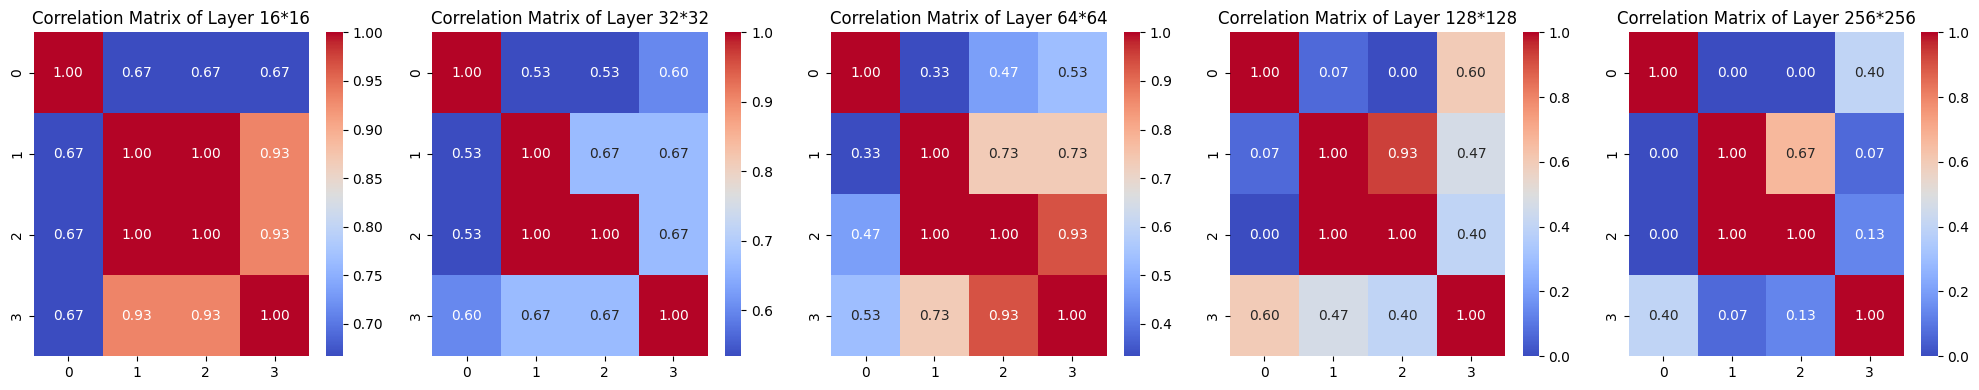

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for i, matr in enumerate(corr_matr):
    sns.heatmap(matr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlation Matrix of Layer {layers[i]}')

plt.tight_layout()
plt.show()

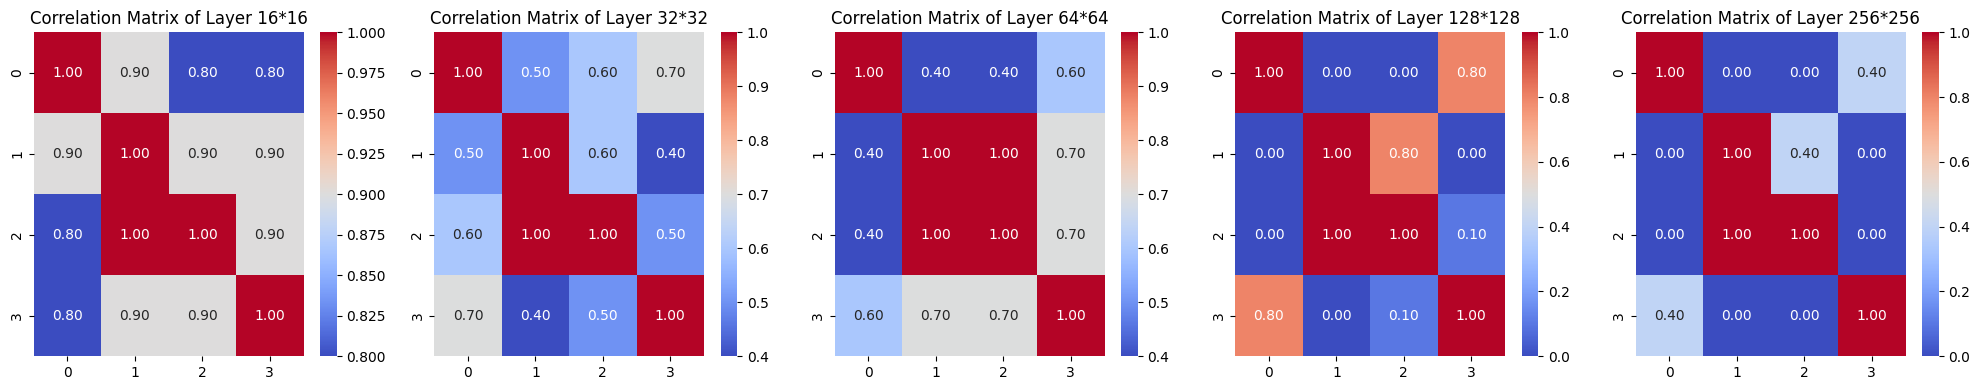

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for i, matr in enumerate(corr_matr):
    sns.heatmap(matr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlation Matrix of Layer {layers[i]}')

plt.tight_layout()
plt.show()

#### Results for man

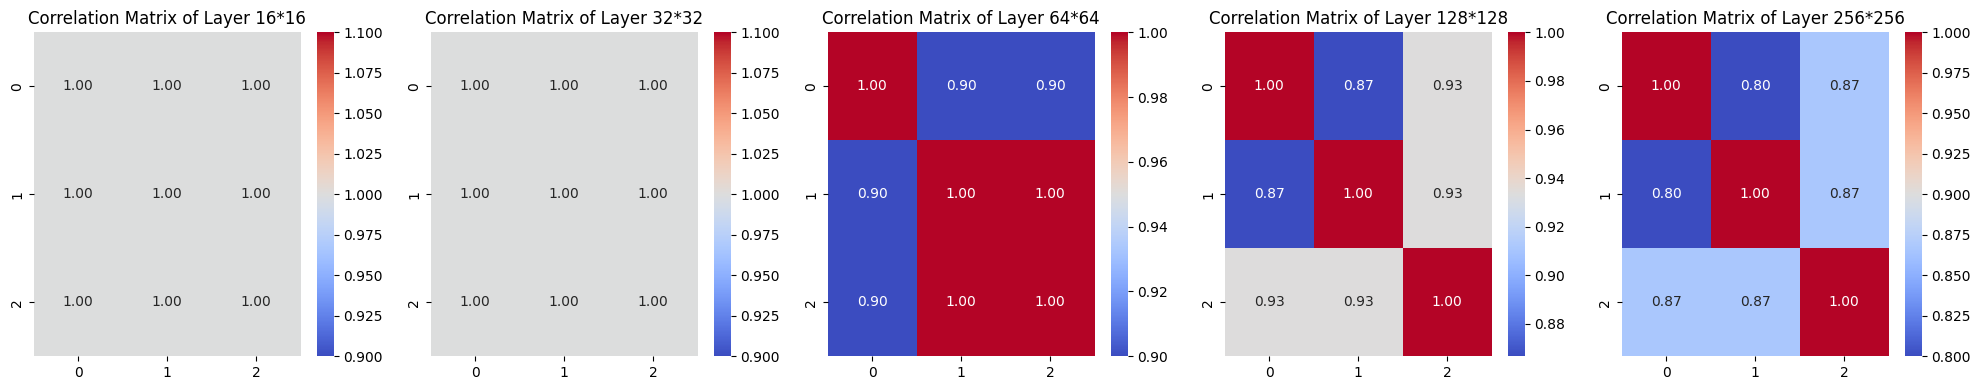

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for i, matr in enumerate(corr_matr):
    sns.heatmap(matr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlation Matrix of Layer {layers[i]}')

plt.tight_layout()
plt.show()

#### Channels L1 norm histograms for various methods

In [ ]:
for i in range(5):
    print(f"Layer {i}")
    print("Max norm:")
    # print(map_norms_interface[i].sort(descending=True).values[0].item())
    print(map_norms_gnaspace[i].sort(descending=True).values[0].item())
    print(map_norms_stylespace[i].sort(descending=True).values[0].item())
    print(map_norms_styleclip[i].sort(descending=True).values[0].item())
    print("Top-5 max norm")
    print(map_norms_interface[i].sort(descending=True).values[4].item())
    print(map_norms_gnaspace[i].sort(descending=True).values[4].item())
    print(map_norms_stylespace[i].sort(descending=True).values[4].item())
    print(map_norms_styleclip[i].sort(descending=True).values[4].item())

    print("Top-10 max norm")
    print(map_norms_interface[i].sort(descending=True).values[9].item())
    print(map_norms_gnaspace[i].sort(descending=True).values[9].item())
    print(map_norms_stylespace[i].sort(descending=True).values[9].item())
    print(map_norms_styleclip[i].sort(descending=True).values[9].item())

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_interface):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_gnaspace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_stylespace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_styleclip):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Man

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_interface):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

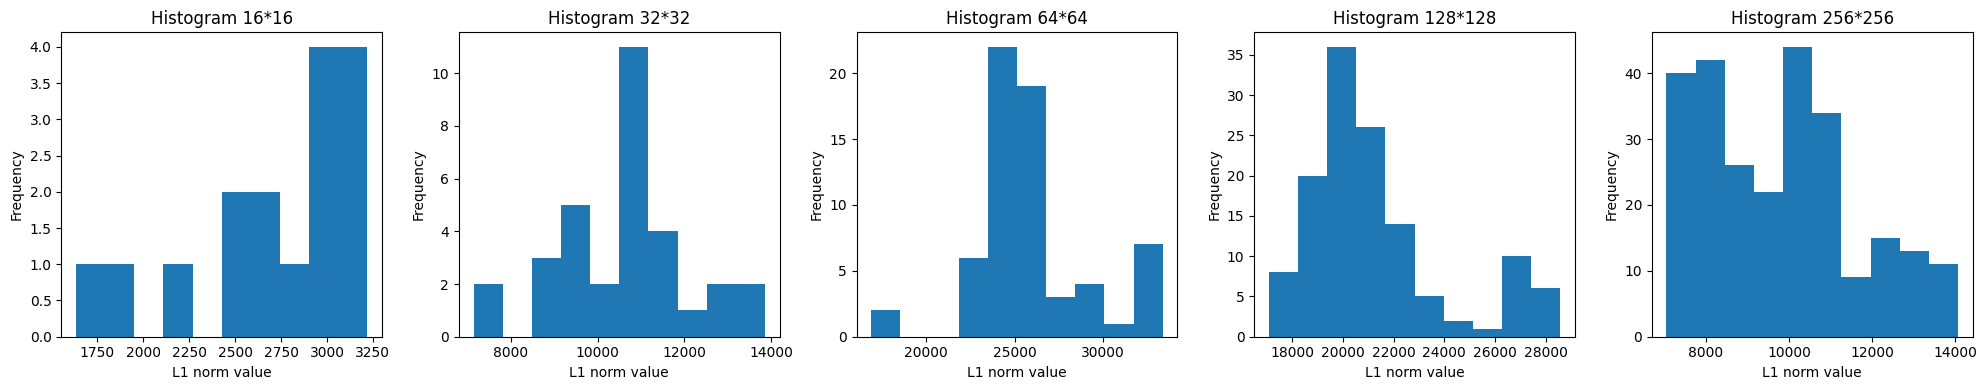

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_gnaspace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

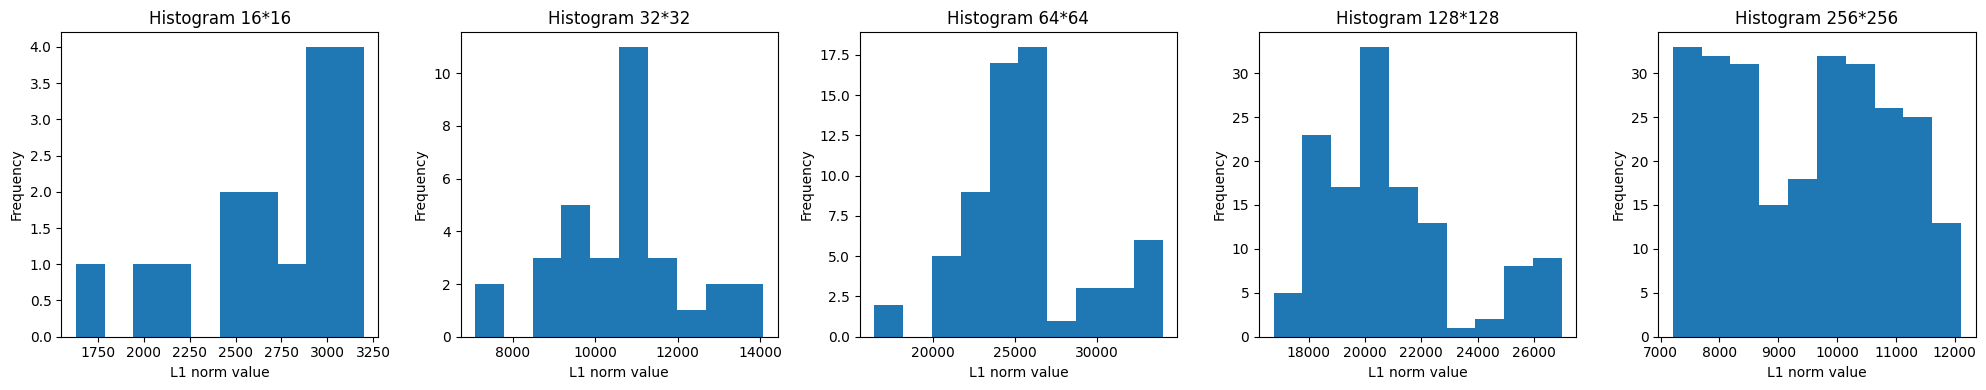

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_stylespace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

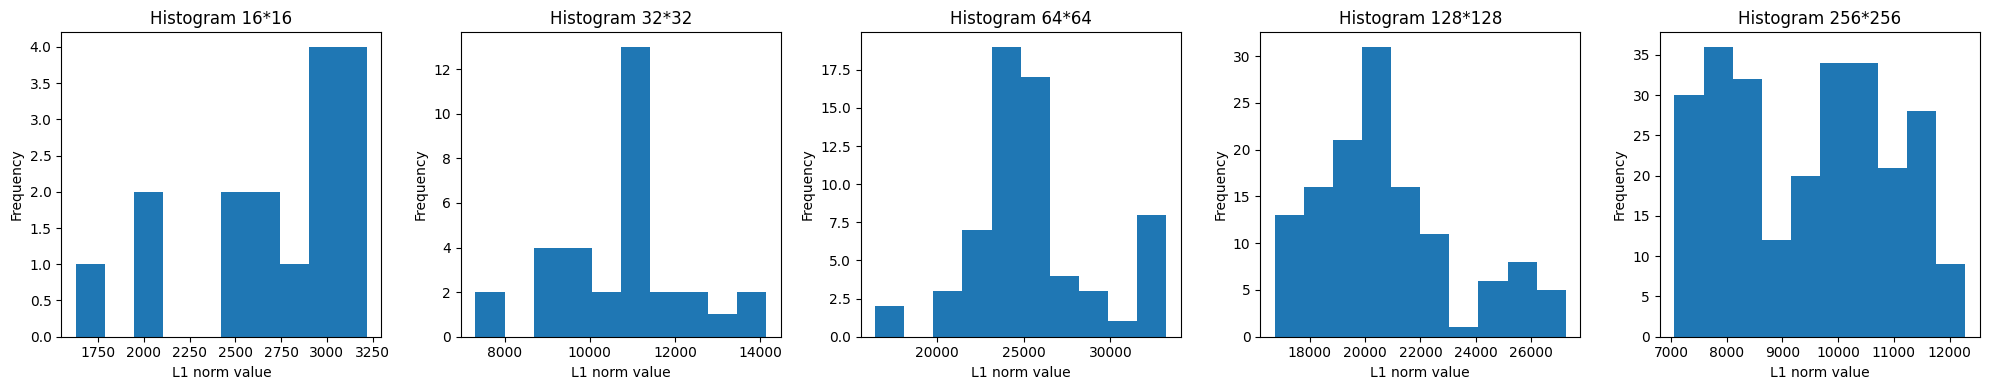

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_styleclip):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## And what's for latent images?

In [ ]:
z = torch.randn(1, 512)
ws1 = net.decoder.get_latent(z.to("cuda:0"))
image, ws = net.decoder([z.to("cuda:0")], input_is_latent=False, return_latents=True)

In [ ]:
ws = torch.tensor(np.load("/content/latent_smile.npy")).cuda()

In [ ]:
image, _ = net.decoder([ws], input_is_latent=True, return_latents=True)

In [ ]:
original_image = tensor2im(image[0])

#### Edits

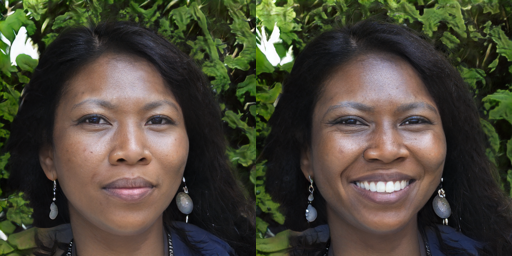

In [ ]:
result = editor.apply_interfacegan(ws, interfacegan_direction, factor=1.6).resize(resize_dims)
edit_latents_interface = apply_interfacegan_latents(ws, interfacegan_direction, factor=1.2)
display_alongside_source_image(result, original_image)

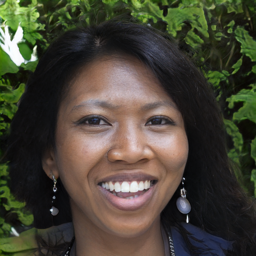

In [ ]:
editor.apply_ganspace(ws, ganspace_pca, [directions["smile"]]).resize((256,256))

In [ ]:
edit_latents_ganspace = apply_ganspace_latents(ws, ganspace_pca, [directions["smile"]])

StyleClip

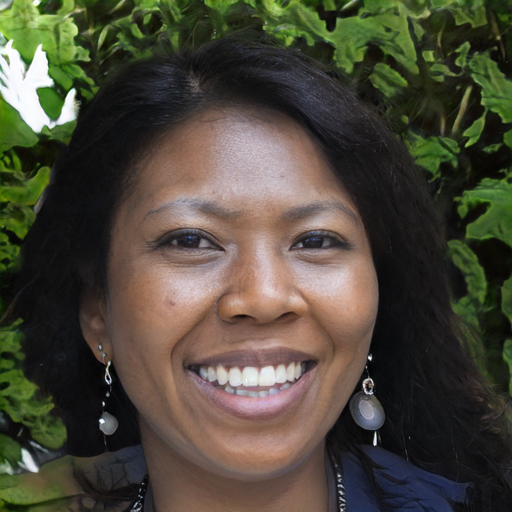

In [ ]:
# if mode == 'real image':
img_index = 0
dlatents_loaded=M.G.synthesis.W2S(ws.detach())

img_indexs=[img_index]
dlatents_loaded=M.S2List(dlatents_loaded)

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
# elif mode == 'generated image':
#   img_indexs=[img_index]
#   dlatents_loaded=M.S2List(dlatents_loaded)
#   dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]

M.num_images=len(img_indexs)
M.alpha=[-6.5]
lindex, cindex = 6, 501

M.manipulate_layers=[lindex]
codes_stylespace,out=M.EditOneC(cindex, dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

In [ ]:
img_index = 0
dlatents_loaded=M.G.synthesis.W2S(ws.detach())

img_indexs=[img_index]
dlatents_loaded=M.S2List(dlatents_loaded)
dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None

In [ ]:
neutral='face' #@param {type:"string"}
target='face with smile' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.2896


num of channels being manipulated: 3


(-0.5, 1023.5, 1023.5, -0.5)

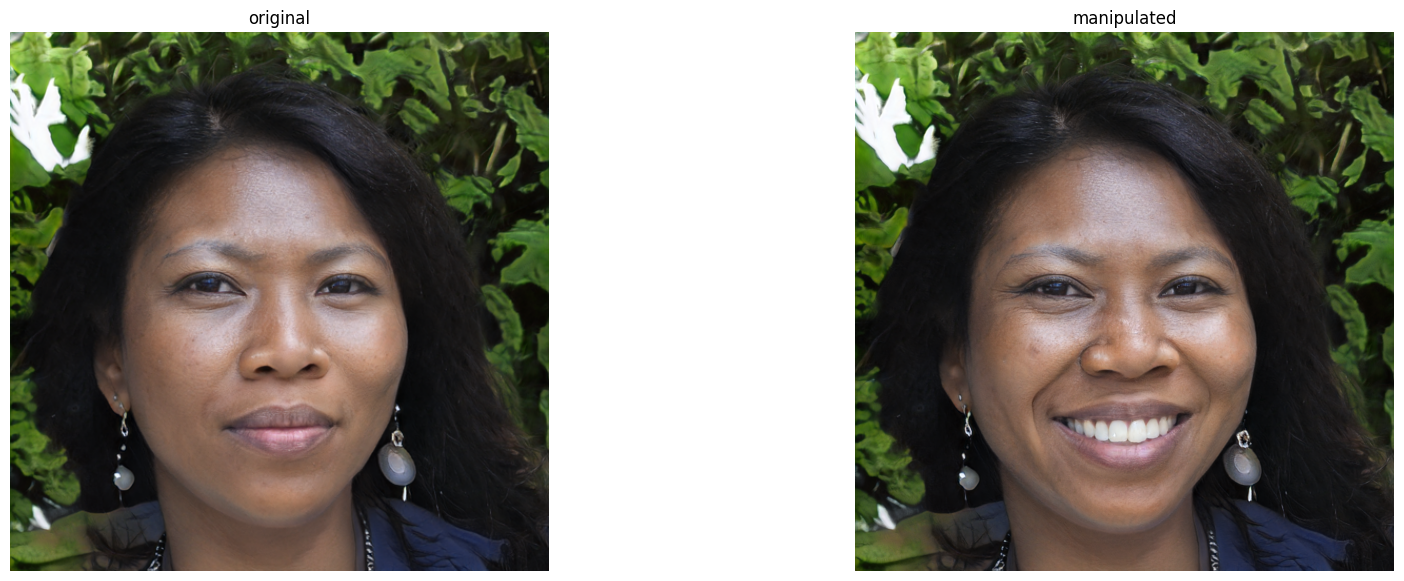

In [ ]:
beta = 0.21 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 4 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes_styleclip=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes_styleclip)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

### Evaluation

In [ ]:
features = get_feature_maps(ws, None)

In [ ]:
interface_features = get_feature_maps(edit_latents_interface, None)
ganspace_features = get_feature_maps(edit_latents_ganspace, None)
stylespace_features = get_feature_maps(None, codes_stylespace)
styleclip_features = get_feature_maps(None, codes_styleclip)

In [ ]:
dif_features_interface, map_norms_interface = find_best_channels(interface_features, features, method_name="interface")

[122 370 440 174  14 250 140 279 387 381]
[432 383 386 268 163  62 152 508 440 150]
[445 311 181 340 107  57 486 256  20 414]
[222  27 174 172 152 130 243  22  92  39]
[ 86 122  42  80  37  95  55  35  94  43]


In [ ]:
dif_features_ganspace, map_norms_gnaspace = find_best_channels(ganspace_features, features, method_name="ganspace")

[389 122 442  92  96 219 370 308 395 118]
[383 163 279  93 432 386 152 508 481 398]
[445 311 107 340 181 414  57 256 486 214]
[ 27 222 174 172 130 152 235  92 101 243]
[ 86 122  42  80  37  95  94  55  43  36]


In [ ]:
dif_features_stylespace, map_norms_stylespace = find_best_channels(stylespace_features, features, method_name="stylespace")

[389 122 442 319 317 492 395 280 381 466]
[383 279 163 152 432 268  51  93 446  62]
[445 311 107 340 181  20 256 414 486 214]
[ 27 130 172  40 174 222 101 235 152  92]
[ 42 122  86  80  95  37  55  35  36  94]


In [ ]:
dif_features_styleclip, map_norms_styleclip = find_best_channels(styleclip_features, features, method_name="styleclip")

[122 370 503  14 250 279 492 442 140 440]
[383 152 432 386  62 163 508 268 392 240]
[445 311 107 340 181 486 256  20 483  84]
[ 27 172 130 222 152 252  92 235 101 113]
[ 42 122  86  95  80  37  55  94  35  36]


### Cor matrix

In [ ]:
corr_matr = []

In [ ]:
for i in range(5):
    print(f"Layer : {i}")
    cur_matr = np.ones((3,3))
    # interface_ganspace =  len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['ganspace'][i])) / denoms[i]
    # interface_stylespace = len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['stylespace'][i])) / denoms[i]
    # interface_styleclip = len(set(argmax_channels_for_methods['interface'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]
    ganspace_stylespace = len(set(argmax_channels_for_methods['ganspace'][i]) & set(argmax_channels_for_methods['stylespace'][i])) / denoms[i]
    ganspace_styleclip = len(set(argmax_channels_for_methods['ganspace'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]
    stylespace_styleclip =  len(set(argmax_channels_for_methods['stylespace'][i]) & set(argmax_channels_for_methods['styleclip'][i])) / denoms[i]

    # cur_matr[0,1] = cur_matr[1,0] =  interface_ganspace
    # cur_matr[0,2] = cur_matr[2,0] =  interface_stylespace
    # cur_matr[0,3] = cur_matr[3,0] =  interface_styleclip
    cur_matr[0,1] = cur_matr[1,0] =  ganspace_stylespace
    cur_matr[0,2] = cur_matr[2,0] =  ganspace_styleclip
    cur_matr[2,1] = cur_matr[1,2] =  stylespace_styleclip


    # print("interface-ganspace",interface_ganspace)
    # print("interface-stylespace", interface_stylespace)
    # print("interface-styleclip",interface_styleclip)

    print("ganspace-stylespace",ganspace_stylespace)
    print("ganspace-styleclip",ganspace_styleclip)
    print("stylespace-styleclip",stylespace_styleclip)

    corr_matr.append(cur_matr)

Layer : 0
ganspace-stylespace 1.0
ganspace-styleclip 1.0
stylespace-styleclip 1.0
Layer : 1
ganspace-stylespace 1.0
ganspace-styleclip 1.0
stylespace-styleclip 1.0
Layer : 2
ganspace-stylespace 0.9
ganspace-styleclip 0.9
stylespace-styleclip 1.0
Layer : 3
ganspace-stylespace 0.8666666666666667
ganspace-styleclip 0.9333333333333333
stylespace-styleclip 0.9333333333333333
Layer : 4
ganspace-stylespace 0.8
ganspace-styleclip 0.8666666666666667
stylespace-styleclip 0.8666666666666667


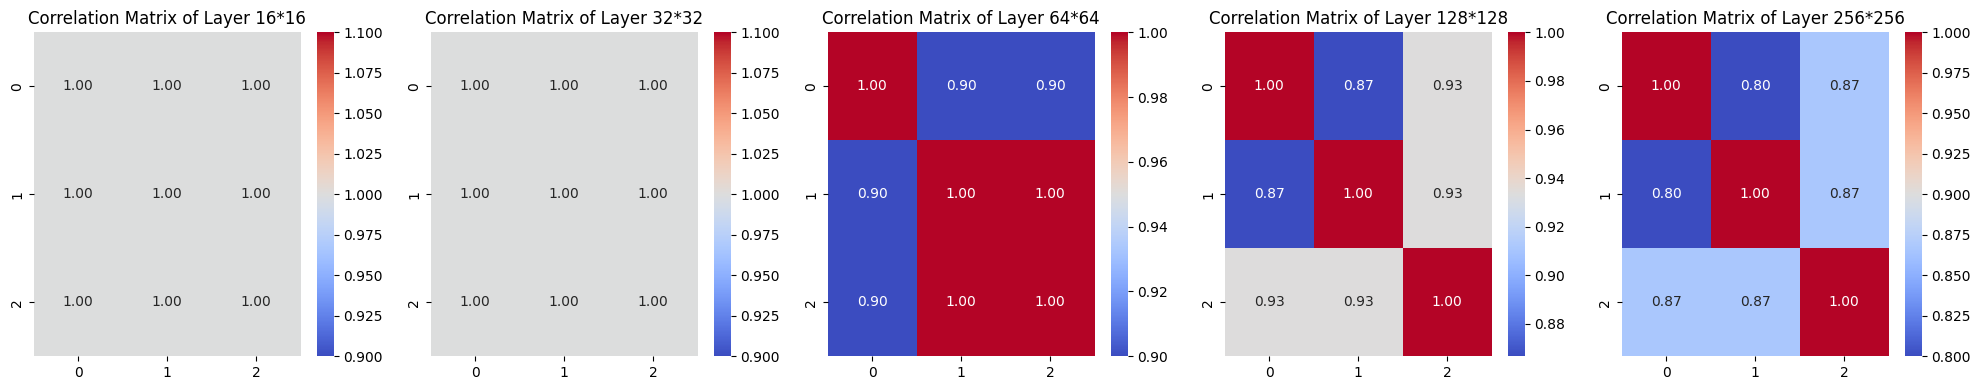

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))


for i, matr in enumerate(corr_matr):
    sns.heatmap(matr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlation Matrix of Layer {layers[i]}')

plt.tight_layout()
plt.show()

### Histograms

Interface hist

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_interface):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

GANSpace Hist

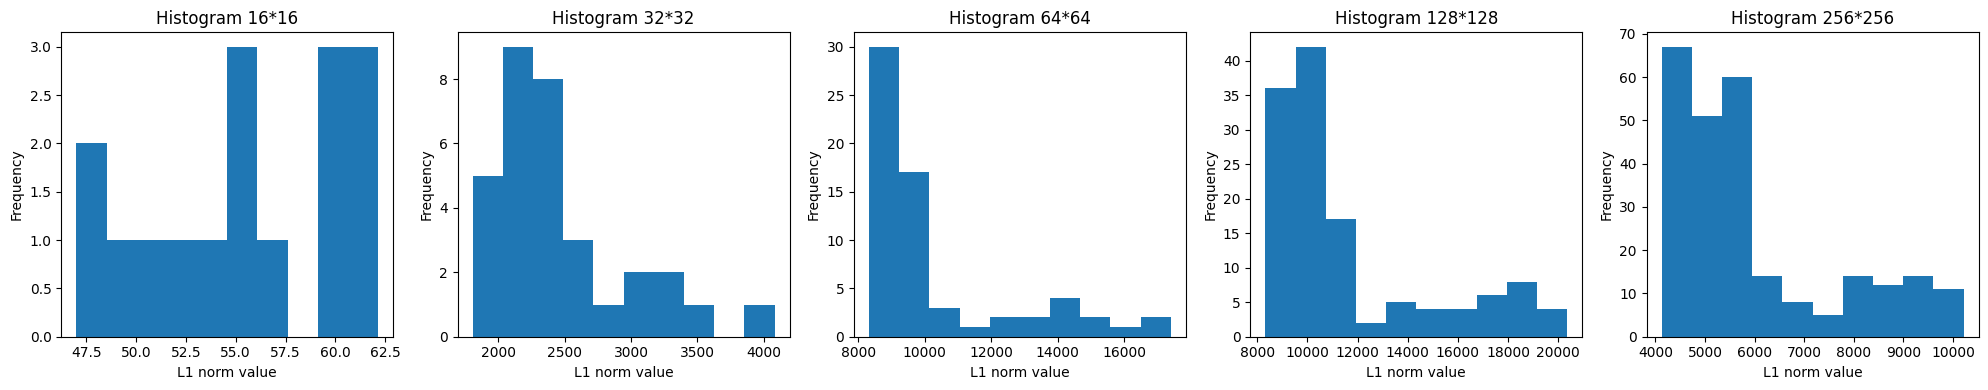

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_gnaspace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

StyleSpace Hist

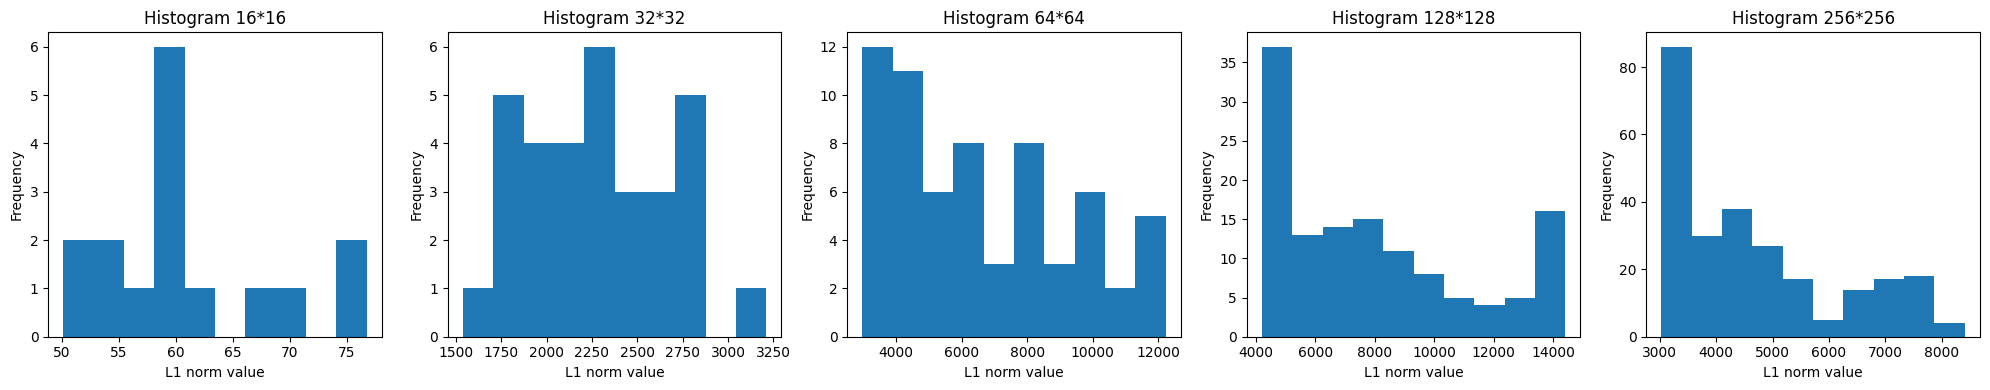

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_stylespace):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

StyleClip Hist

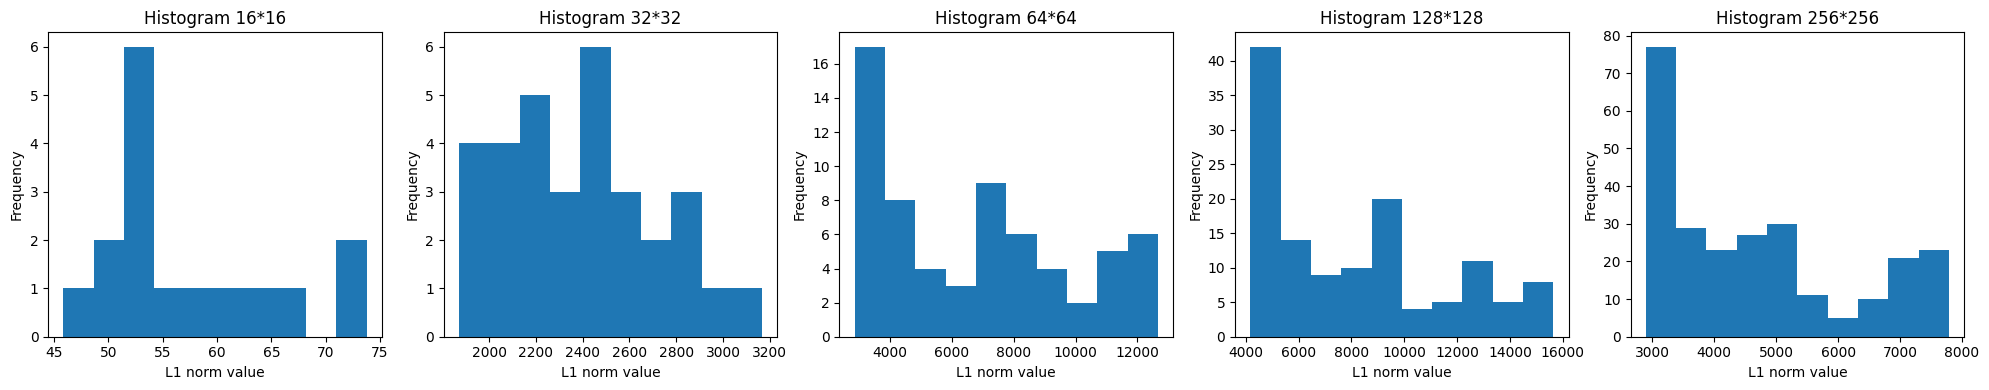

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, data in enumerate(map_norms_styleclip):
    axes[i].hist(data.detach().cpu().numpy())
    axes[i].set_title(f'Histogram {layers[i]}')
    axes[i].set_xlabel('L1 norm value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()